Object detection using YOLO

Import necessary libraries and packages

In [ ]:
import zipfile # it helps us to extract or compress any files or folders
import requests # inorder to download dataset
import cv2 # opencv library for image processing (reading, writing,..)
import matplotlib.pyplot as plt #visualise and plot graph
import glob #find the patterns based on rules used by unix shell
import random #provide function to generate random numbers
import os #interact with the native operating system

Now install the ultralytics package

In [ ]:
!pip install ultralytics

Loading the Dataset (#labelled dataset)

In [ ]:
os.makedirs('datasets', exist_ok=True)

In [ ]:
%cd datasets

In [ ]:
def download_file(url, local_filename):
  url = url
  if not os.path.exists(local_filename):
      file = requests.get(url)
      open(local_filename, 'wb').write(file.content)

download_file('https://www.dropbox.com/s/qvglw8pqo16769f/pothole_dataset_v8.zip?dl=1','pothole_dataset_v8.zip')

Unzip the datafile

In [ ]:
def unzip(zip_file = None):
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall("./")
            print("extracted all")
    except:
        print("Invalid file")

unzip('pothole_dataset_v8.zip')


In [ ]:
%cd ..

Visualization of Images from the Dataset

In [ ]:
#function to convert bounding boxes in YOLO format to xmin, ymin xmax, ymax

def yolo2bbox(bboxes):
  xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
  xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
  return xmin, ymin, xmax, ymax

In [ ]:
#The plot_box function takes an image and a list of bounding boxes (in YOLO format), denormalizes the coordinates, and then draws these bounding boxes on the image in red.
def plot_box(image, bboxes, labels):


  height, width, _ = image.shape #h,w,channel
  for box_num, box in enumerate(bboxes): #index,cordinate,count
      x1,y1,x2,y2 = yolo2bbox(box)

      #denormalize the cordinators
      xmin = int(x1*width)
      ymin = int(y1*height)
      xmax = int(x2*width)
      ymax = int(y2*height)

      thickness = max(2, int(width/275))

      cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color = (0,0,255), thickness = thickness)

  return image



In [ ]:
#function to plot images with the bounding boxes

def plot(image_paths, label_paths, num_samples):
  all_images = []
  all_images.extend(glob.glob(image_paths+'/*.jpg'))
  all_images.extend(glob.glob(image_paths+'/*.JPG'))

  all_images.sort()

  num_images = len(all_images)

  plt.figure(figsize=(15,12))
  for i in range(num_samples):
      j = random.randint(0, num_images-1)
      image_name = all_images[j]
      image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
      image = cv2.imread(all_images[j])
      with open(os.path.join(label_paths,image_name+'.txt'),'r')as f:
          bboxes = []
          labels = []
          label_lines = f.readlines()
          for label_line in label_lines:
              label = label_line[0]
              bbox_string = label_line[2:]
              x_c, y_c, w, h = bbox_string.split(' ')
              x_c = float(x_c)
              w = float(w)
              y_c = float(y_c)
              h = float(h)
              bboxes.append([x_c, y_c, w, h])
              labels.append(label)
      result_image = plot_box(image, bboxes, labels)
      plt.subplot(2,2,i+1)
      plt.imshow(result_image[:,:,::-1])
      plt.axis('off')
  plt.subplots_adjust(wspace=1)
  plt.tight_layout()
  plt.show()


Let's try visualizing few training images

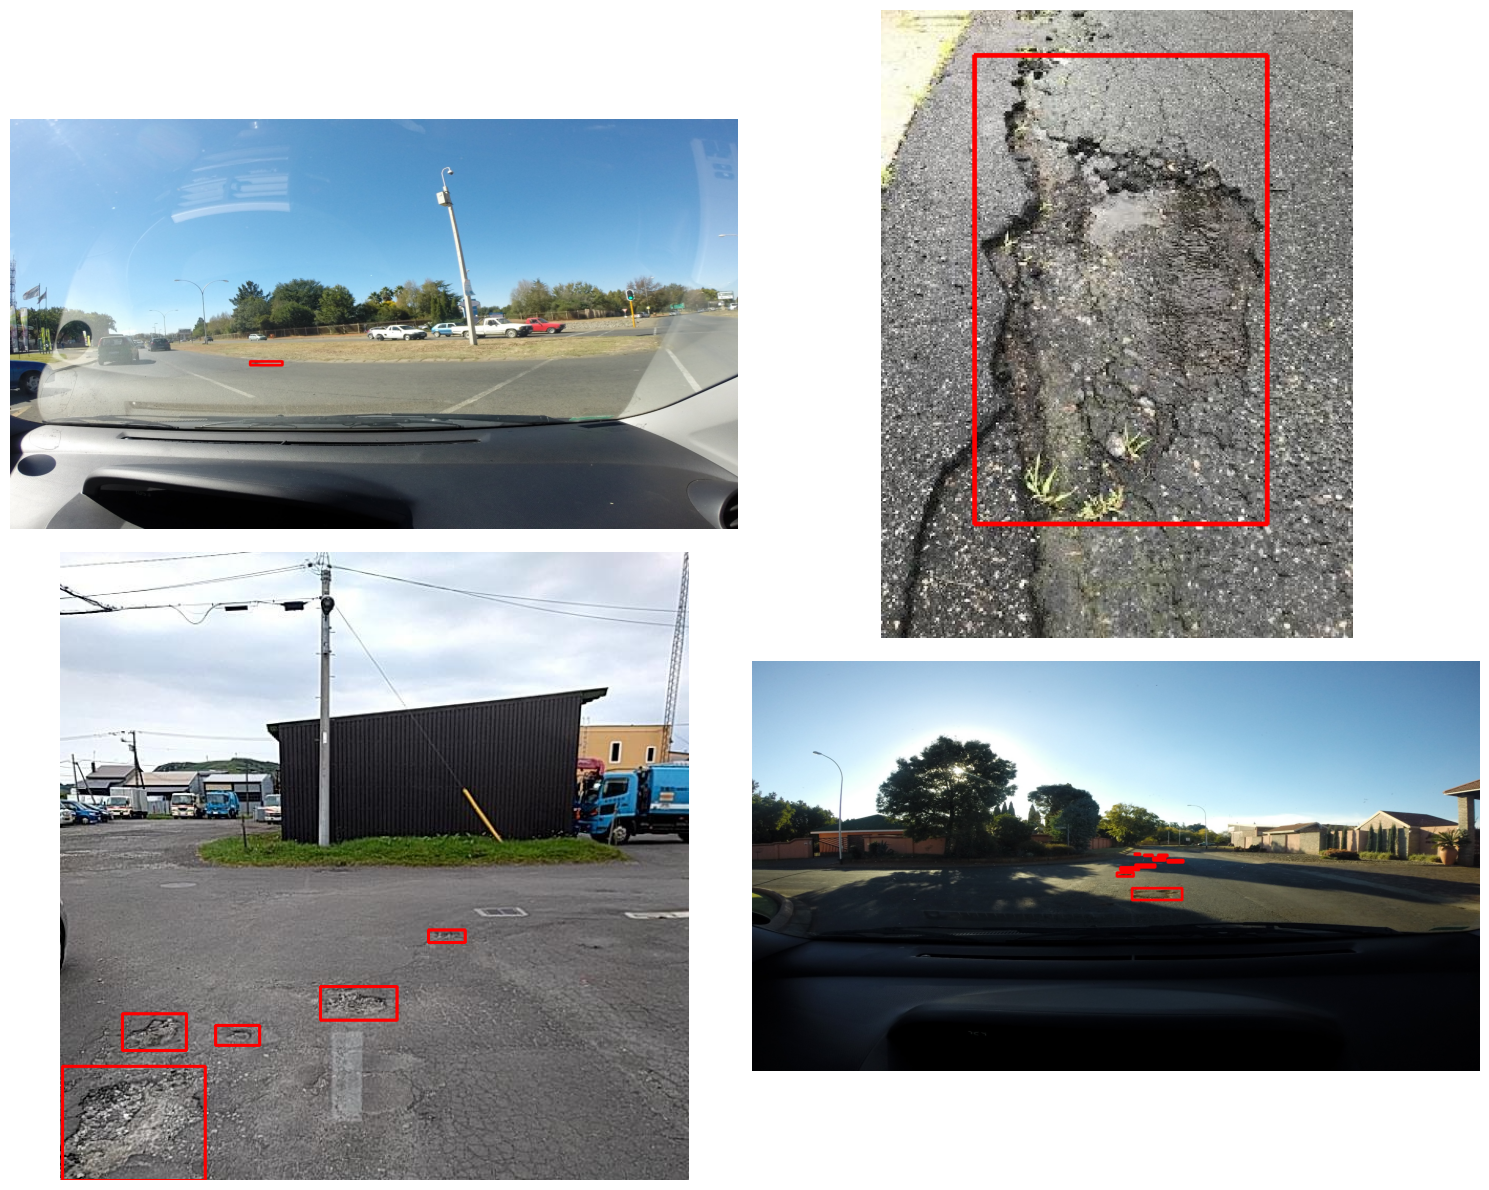

In [ ]:
plot(
    image_paths='datasets/pothole_dataset_v8/train/images/',
    label_paths='datasets/pothole_dataset_v8/train/labels/',
    num_samples=4,
)

Define the path structure in Dataset YAML File

In [ ]:
%%writefile pothole_v8.yaml
path: 'pothole_dataset_v8/'
train: 'train/images'
val: 'valid/images'

#classnames
names:
  0: 'pothole'

Training the YOLOn Model (Nano ver)

In [ ]:
EPOCHS = 5
!yolo task=detect mode=train model=yolov8n.pt imgsz=1280 data=pothole_v8.yaml epochs={EPOCHS} batch=8 name=yolov8n_v8_50e

saving the model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
model_save_path = '/content/gdrive/MyDrive/PotHole_Detection_using_YOLOv8/PotHOleYOLOv8.pt'

In [ ]:
!cp -r /content/yolov8n.pt /content/gdrive/MyDrive/PotHole_Detection_using_YOLOv8/PotHOleYOLOv8.pt

validation

In [ ]:
!yolo task=detect mode=val model=/content/yolov8n.pt name=yolov8n_eval data=pothole_v8.yaml

Confusion matrix

In [ ]:
#reading the image
img = plt.imread("/content/runs/detect/yolov8n_eval/confusion_matrix.png")

#create a plot and display the image
plt.imshow(img)
plt.axis('off')

plt.show()

Analysis

In [ ]:
image_paths = [
    './runs/detect/yolov8n_eval/F1_curve.png',
    './runs/detect/yolov8n_eval/PR_curve.png',
    './runs/detect/yolov8n_eval/P_curve.png',
    './runs/detect/yolov8n_eval/R_curve.png',

]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, ax in enumerate(axes.flat):
    img = plt.imread(image_paths[i])
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()

plt.show()

Inference on validation Images

In [ ]:
!yolo task=detect \
mode=predict \
model=runs/detect/yolov8n_v8_50e/weights/best.pt \
source=datasets/pothole_dataset_v8/valid/images \
imgsz=1280 \
name=yolov8n_v8_50e_infer1280 \
hide_labels=True

Visualise validation Results

In [ ]:
#plot and visualise images in 2x2 grid
def visualize(result_dir, num_samples=4):
    plt.figure(figsize=(20,12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2,2,i+1)
        plt.imshow(image)
        plt.axis('off')
        if i==num_samples-1:
          break
    plt.tight_layout()
    plt.show()

In [ ]:
visualize('runs/detect/yolov8n_v8_50e_infer1280/')